In [68]:
import pickle
import os
from utils import *
import torch
from torch.utils.data import Dataset, DataLoader
from data_loader import *
import torch.nn as nn
from pytorch_model import test
from sklearn import metrics
import matplotlib.pyplot as plt
from model.architecture import Net, RNN
from sklearn.manifold import TSNE

In [69]:
TEST_FILE = 'processed/holdout-dev.pkl'

In [70]:
test_data = pickle.load(open(TEST_FILE, 'rb'))

In [71]:
########### ONLY NEED TO USE THESE
strip = True
classify = True
collate_fn = "sum" # "avg"
use_spellcheck = False
model_pth = 'saved_models/nn-classify.model'
###########

remove_numbers = False

In [72]:
normalize = True
test_answers, test_scores = prepare_data(test_data, normalize, strip)

In [6]:
glove_dim = 200
glove_home = os.path.join('vsmdata', 'glove.6B')
glove_lookup = glove2dict(os.path.join(glove_home, 'glove.6B.%dd.txt' % glove_dim))

In [73]:
test_x = []

for test_answer in test_answers:
    # features = process(test_answer, glove_lookup, remove_numbers, use_spellcheck)
    features = embed(test_answer, glove_lookup, dim=glove_dim, collate_fn=collate_fn)
    #if not isinstance(features, float):
    test_x.append(features)

In [74]:
# We want to use the classify model
threshold = 1.0
if classify:
    test_y = np.array([1.0 if x >= threshold else 0.0 for x in test_scores])
else:
    test_y = test_scores

In [75]:
test_x = np.array(test_x)
test_y = test_y.reshape(-1, 1)
print(test_x.shape, test_y.shape)

(362, 200) (362, 1)


In [76]:
SEED = 1
NO_CUDA = False
BATCH_SIZE = 10

In [88]:
use_cuda = not NO_CUDA and torch.cuda.is_available()

torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

test_loader = DataLoader(
    BowDataset(test_x, test_y),
    batch_size=BATCH_SIZE, shuffle=False)

n_features = test_x.shape[1]

if classify:
    criterion = nn.BCELoss()
else:
    criterion = nn.MSELoss()

In [89]:
model = Net(n_features, classify).to(device)
model.load_state_dict(torch.load(model_pth))

In [90]:
test_true, test_pred, _, embeds = test(model, device, test_loader, criterion, classify)

Test loss: 0.6534963250160217 Test f1: 0.5722543352601156


In [93]:
import pickle
import argparse
import random
import numpy as np
import time
import os
import sys
import utils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from split_data import holdout_split

import matplotlib.pyplot as plt
from utils import *
from vocab import Vocabulary

holdout = True
direc = 'processed/' 
TRAIN_FILE = direc + '%strain.pkl' % ('holdout-' if holdout else '')
DEV_FILE = direc + '%sdev.pkl' % ('holdout-' if holdout else '')
TEST_FILE = direc + '%stest.pkl' % ('holdout-' if holdout else '')
PROBLEMS = ['1a', '1b', '1c', '1d', '2', '3a', '3b', '4', '5', '6', '7']
PROBLEMS = ['1c']

print("Loading training data...")
# train_data = pickle.load(open(TRAIN_FILE, 'rb'))
# dev_data = pickle.load(open(DEV_FILE, 'rb'))
total = 0.0
best = 0
best_q = ''
best_devx = None
best_devy = None
train_data, dev_data, _ = holdout_split('1c', '1c')

# answers is list of strings, scores is numpy array of shape (len,)
train_answers, train_scores = prepare_data(train_data, True, True)
dev_answers, dev_scores = prepare_data(dev_data, True, True)
print(" - done.")

train_x = train_answers
dev_x = dev_answers
threshold = 0.5
train_y = np.array([1.0 if x >= threshold else 0.0 for x in train_scores])
dev_y = np.array([1.0 if x >= threshold else 0.0 for x in dev_scores])

print("Transforming answers")	

cv = CountVectorizer()
train_x = cv.fit_transform(train_x).toarray()
dev_x = cv.transform(dev_x).toarray()
print("Train size: {} Dev size: {}".format(train_x.shape, dev_x.shape))

model = LogisticRegression()
model.fit(train_x, train_y)
train_pred = model.predict(train_x)
precision, recall, f1, _ = metrics.precision_recall_fscore_support(train_y, train_pred, average='binary')
print("Train f1: {}".format(f1))

dev_pred = model.predict(dev_x)
dev_true = dev_y
precision, recall, f1, _ = metrics.precision_recall_fscore_support(dev_true, dev_pred, average='binary')
metric = f1
print("Dev f1: {}".format(f1))

total += metric
if metric > best:
    best = metric
    best_devx = dev_true
    best_devy = dev_pred

print('best:', best, 'average:', total / len(PROBLEMS))

Loading dataset into memory...
Parsed 7342 student answers.
- done.
Loading training data...
Train size: 6980 Dev size: 362 Test size: 0
 - done.
Transforming answers
Train size: (6980, 4953) Dev size: (362, 4953)
Train f1: 0.9613570541994209
Dev f1: 0.9380530973451328


NameError: name 'prob' is not defined

In [80]:
if classify:
    metric = metrics.precision_recall_fscore_support(test_true, test_pred, average='binary')
    print(metric)
    print("Test precision {} recall {} f1{}".format(metric[0], metric[1], metric[2]))
else:
    metric = metrics.r2_score(test_true, test_pred)
    print("Test r2 {}".format(metric))

(0.44, 0.8181818181818182, 0.5722543352601156, None)
Test precision 0.44 recall 0.8181818181818182 f10.5722543352601156


In [94]:
embeds = dev_x
embeds = np.array(embeds)
print(type(embeds))
print(embeds.shape) # want (372, 50)

<class 'numpy.ndarray'>
(362, 4953)


In [95]:
X_embedded = TSNE(n_components=2).fit_transform(embeds)
print(X_embedded.shape) # want (372, 2)

(362, 2)


In [96]:
#indices_nonzero = np.nonzero(train_scores)
zero_indices = np.argwhere(test_scores.squeeze() != 1)
one_indices = np.argwhere(test_scores.squeeze() == 1)

In [97]:
X_embedded_zero = X_embedded[zero_indices].squeeze()
X_embedded_one = X_embedded[one_indices].squeeze()
print("Zero t-sne shape:", X_embedded_zero.shape) # Should be (314, 2)
print("One t-sne shape:", X_embedded_one.shape) # Should be (48, 2)

Zero t-sne shape: (241, 2)
One t-sne shape: (121, 2)


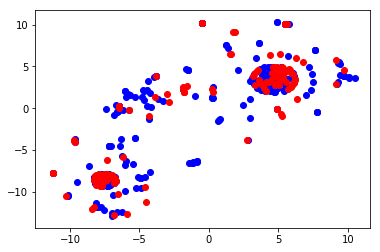

In [98]:
plt.scatter(X_embedded_zero[:,  0],  X_embedded_zero[:,  1],  color='b', label='blue')
plt.scatter(X_embedded_one[:,  0],  X_embedded_one[:,  1],  color='r', label='red')

In [101]:
list(zip(dev_answers, dev_pred, dev_true))

[('print out all values in the given cashman you are guaranteed that each value in the map is unique thus you don t need to worry about duplicates private void print values cash map string string map for string key map print map get key',
  1.0,
  1.0),
 ('print out all values in the given cashman you are guaranteed that each value in the map is unique thus you don t need to worry about duplicates private void print values cash map string string map for key type key map key get string str map get key print str',
  1.0,
  1.0),
 ('print out all values in the given cashman you are guaranteed that each value in the map is unique thus you don t need to worry about duplicates private void print values cash map string string map for string key map key get print key print map get key',
  1.0,
  1.0),
 ('print out all values in the given cashman you are guaranteed that each value in the map is unique thus you don t need to worry about duplicates private void print values cash map string string